<a href="https://colab.research.google.com/github/bastian110/LiverTumor_SegmentationAndClassification/blob/main/classifier_transfert_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms, models
import torchvision.transforms as transforms

import os
import time
import copy
import csv

import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/tp_DL/datatraintest.zip

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation (test)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/content/data_png"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

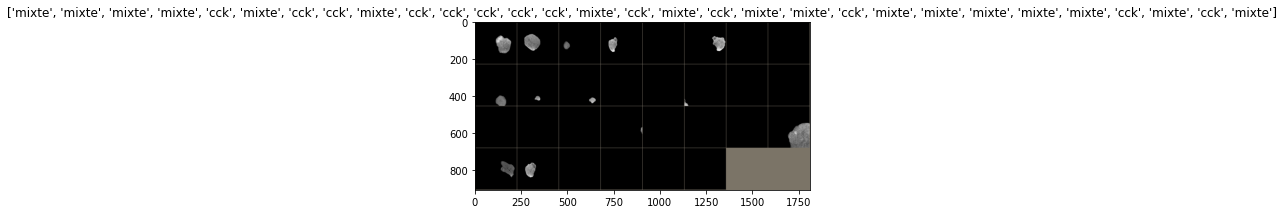

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
!pip install torchmetrics

     |████████████████████████████████| 397 kB 7.6 MB/s 


In [ ]:
import csv
with open('innovators.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["SN", "Name", "Contribution"])
    writer.writerow([1, "Linus Torvalds", "Linux Kernel"])
    writer.writerow([2, "Tim Berners-Lee", "World Wide Web"])
    writer.writerow([3, "Guido van Rossum", "Python Programming"])

In [53]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score, recall_score

# recall, f1-score,AUC 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_metric_log = [["phase", "epoch_loss", "epoch_acc", "precision", "f1_score"]]
    test_metric_log = [["phase", "epoch_loss", "epoch_acc", "precision", "f1_score"]]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            preds_cpu = []
            labels_cpu =[]
            epoch_loss = 0
            epoch_acc = 0
            f1_score = 0
            precision = 0


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                   

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)#number of correct predictions


            if phase == 'train':
                scheduler.step()
            
            preds = preds.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            preds_cpu.extend(preds)
            labels_cpu.extend(labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(preds_cpu, labels_cpu)
            precision = precision_score(preds_cpu, labels_cpu)
            recall = recall_score(preds_cpu, labels_cpu)
            f1_score = 2 * (precision * recall) / (precision + recall)
            #aoc_roc = auroc(preds_cpu, labels_cpu)

            if phase == 'train':
                train_metric_log.append([phase, epoch_loss, epoch_acc, precision, f1_score])
                #print("train log:",train_metric_log)
                df = pd.DataFrame(train_metric_log)
                df.to_csv('train_log.csv')

            else:
                test_metric_log.append([phase, epoch_loss, epoch_acc, precision, f1_score])
                #print("test log:",test_metric_log)
                df2 = pd.DataFrame(test_metric_log)
                df2.to_csv('test_log.csv')

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} f1_score: {:.4f} '.format(
                phase, epoch_loss, epoch_acc, precision, f1_score))


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [59]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [27]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [54]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4)


Epoch 0/3
----------
train Loss: 0.5507 Acc: 0.7692 Precision: 0.5714 f1_score: 0.7273 
test Loss: 0.6224 Acc: 0.5769 Precision: 1.0000 f1_score: 0.7179 

Epoch 1/3
----------
train Loss: 0.5480 Acc: 0.5385 Precision: 0.2500 f1_score: 0.4000 
test Loss: 0.6104 Acc: 0.6154 Precision: 0.9375 f1_score: 0.7500 

Epoch 2/3
----------
train Loss: 0.5504 Acc: 0.8462 Precision: 0.6667 f1_score: 0.8000 
test Loss: 0.6205 Acc: 0.7308 Precision: 0.9500 f1_score: 0.8444 

Epoch 3/3
----------
train Loss: 0.5581 Acc: 0.6923 Precision: 0.5000 f1_score: 0.6667 
test Loss: 0.6225 Acc: 0.5385 Precision: 1.0000 f1_score: 0.7000 

Training complete in 0m 32s
Best val Acc: 0.730769


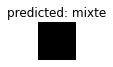

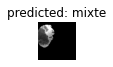

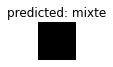

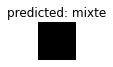

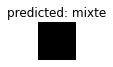

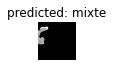

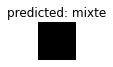

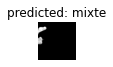

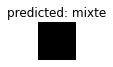

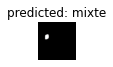

In [60]:
visualize_model(model_conv)

In [61]:
torch.save(model_conv.state_dict(), 'model_weights.pth')